In [1]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 688.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 19.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import re
from wordcloud import WordCloud

import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")
from nltk.stem import WordNetLemmatizer
import pymorphy2
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
#import transformers
#import torch
#import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
#from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
#from transformers import BertTokenizer, BertModel, BertConfig

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
train = pd.read_csv('../input/scan-classification-challange/df_train.csv')
train.sample(3)

,text,class
2332,"Так, курдские боевики вознамерились захватить ...",Теракт
34806,- За первые четыре месяца 2021 года управление...,O
46691,Поэтому Армен Гаспарян посоветовал спонсорам Ф...,O


In [4]:
# Данные представлены двумя текстовыми столбцами
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    60000 non-null  object
 1   class   60000 non-null  object
dtypes: object(2)
memory usage: 937.6+ KB


In [5]:
# Удаляем дубликаты

train.drop_duplicates(subset={'text'}, inplace=True) 
train.shape

(59402, 2)

In [6]:
# Посмотрим количество текста по каждому классу

train['class'].value_counts()

O                                                   40159
Теракт                                               1837
Взятки                                               1775
Экстремизм                                           1744
Уголовное обвинение                                  1543
Пожары                                               1500
Привлечение к уголовной ответственности              1390
Землетрясение                                         827
Утечка нефти                                          799
Противодействие коррупции                             695
Заключение под стражу                                 667
Поддержка террористов                                 653
Коррупция                                             593
Нарушение закона                                      576
Уголовное задержание                                  500
Наводнение                                            483
Кораблекрушение                                       372
Авиакатастрофа

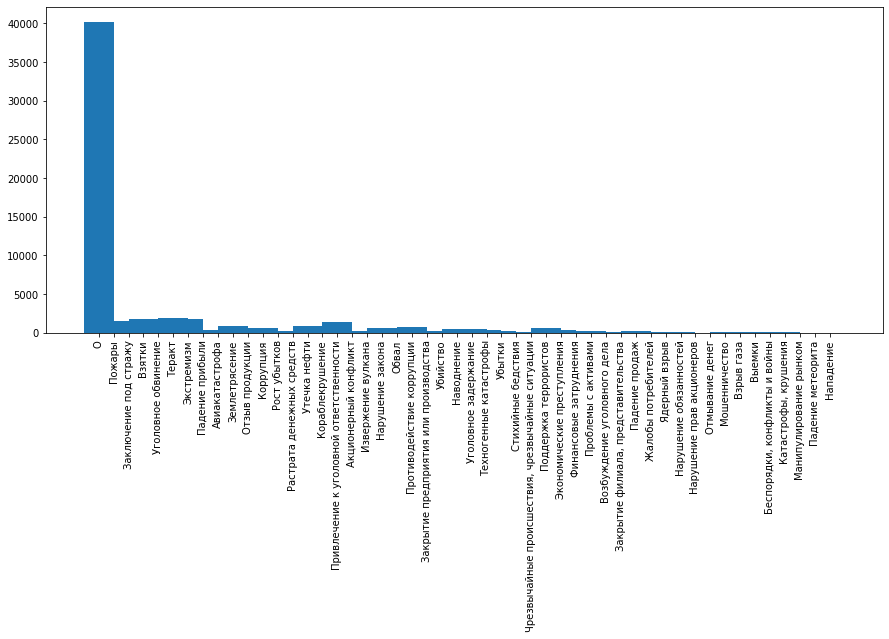

In [7]:
# Видно, что данные сильно не сбалансированны, поэтому простые оценки качества модели, например, accuracy нам не подходят, возьмем f1_score
# Самый большой класс содержит более 40000 значений (2/3 от всех данных)
# Есть классы содержащие по 2 значения

from collections import Counter
counter = Counter(train['class'])
plt.figure(figsize=(15, 6))
plt.bar(counter.keys(), counter.values(), width=2)
plt.xticks(rotation=90)
plt.show()

In [8]:
# Названия категорий переводим в числовой формат и записываем в отдельный столбец

train['encoded_cat'] = train['class'].astype('category').cat.codes
train.sample(3)

,text,class,encoded_cat
26256,Об этом в четверг сообщило сирийское агентство...,O,0
7267,Минобороны Армении сообщило о боях в ночь на с...,O,0
23038,"Первый раз этот аферист, будучи вице-премьером...",O,0


In [9]:
train[['class', 'encoded_cat']].value_counts()

class                                             encoded_cat
O                                                 0              40159
Теракт                                            38              1837
Взятки                                            5               1775
Экстремизм                                        48              1744
Уголовное обвинение                               43              1543
Пожары                                            31              1500
Привлечение к уголовной ответственности           32              1390
Землетрясение                                     12               827
Утечка нефти                                      44               799
Противодействие коррупции                         34               695
Заключение под стражу                             9                667
Поддержка террористов                             30               653
Коррупция                                         16               593
Нарушение закон

(143.69058280865963, 72.06339635294306, 400, 7)

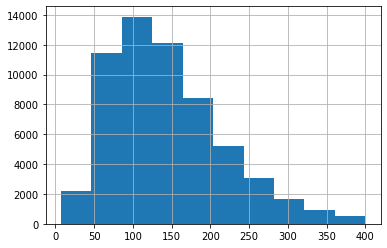

In [10]:
# Средняя длина, стандартное отклонение, макс.длина столбца, мин.длина стобца text по количеству символов
# 
lens = train.text.str.len()
lens.hist()
lens.mean(), lens.std(), lens.max(), lens.min()

In [11]:
# Создадим функцию по очистке данных. Будем переводить слова в нижний регистр, 
# удалять стоп слова, удалять числа и раздичные знаки которые не несут смысловой нагрузки. 
# Все слова преобразуем к их первоначалоной форме (Лемматизация)

nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()
patterns = "[A-Z|a-z|0-9!#$%&'()*+,./:“″;”<=>?@[\]^_`{|}~—\"\-•–«»]+"
#stops = set(stopwords.words("russian"))
def clean(text):
    text = text.lower()
    text = re.sub(patterns, ' ', text)
    tokens = []
    for token in text.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]  # Лемматизация
            #token = stemmer.stem(token) # Стеммизация
            tokens.append(token)
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Применим функцию очистки к train

train['clean'] = train['text'].apply(lambda x: clean(x))
train[['clean', 'text']].sample(3)

,clean,text
34845,также кынев отметить арест мэр краснодар стоят...,"Также Кынев отметил, что за арестом мэра Красн..."
13948,рабочий перуанский пляж ликвидировать разлить ...,Рабочие на перуанском пляже ликвидируют разлив...
52228,возместить млн рубль уточнить рахимов,"Он возмещен на 100 млн рублей, уточнил Рахимов."


(117.14602201946063, 61.17282842523462, 372, 0)

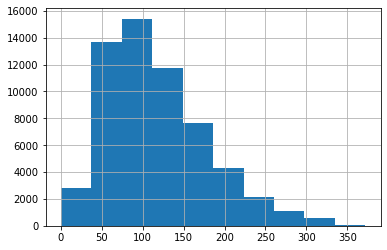

In [13]:
lens_clean = train.clean.str.len()
lens_clean.hist()
lens_clean.mean(), lens_clean.std(), lens_clean.max(), lens_clean.min()

In [14]:
# Выведем список частовстречающихся слов

words = list( train['clean'].values)

split_words=[]
for word in words:
    lo_w=[]
    list_of_words=str(word).split()
    for w in list_of_words:
        if w not in stopwords_ru:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []
for wordlist in split_words:
    allwords += wordlist

In [15]:
# Получим 10 часто встречающихся слов

from nltk import FreqDist
word_freq = FreqDist(allwords).most_common(10)
word_freq

[('год', 9956),
 ('который', 6320),
 ('дело', 5439),
 ('сообщить', 5086),
 ('суд', 5013),
 ('заявить', 4386),
 ('россия', 3582),
 ('это', 3422),
 ('сказать', 3244),
 ('свой', 3222)]

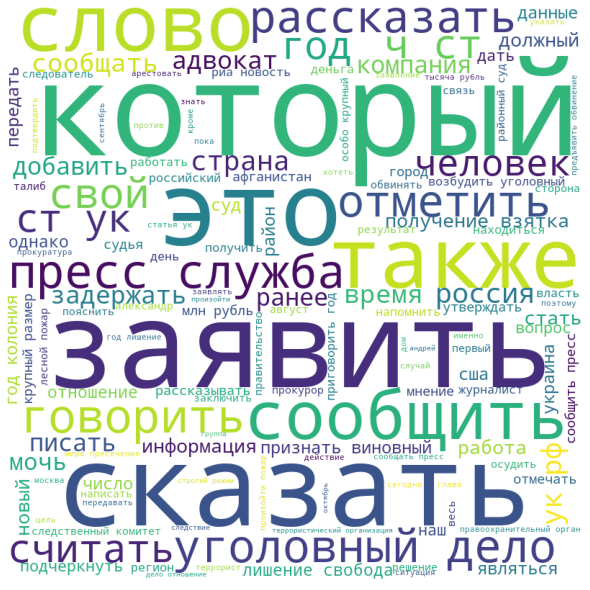

In [16]:
# Выведем WordCloud

comment_words = ''
comment_words += " ".join(allwords)+" " 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords_ru,
                min_font_size = 10).generate(comment_words)                     
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

Text(0.5, 1.0, 'Пары слов встречающиеся в тексте')

<Figure size 1440x1440 with 0 Axes>

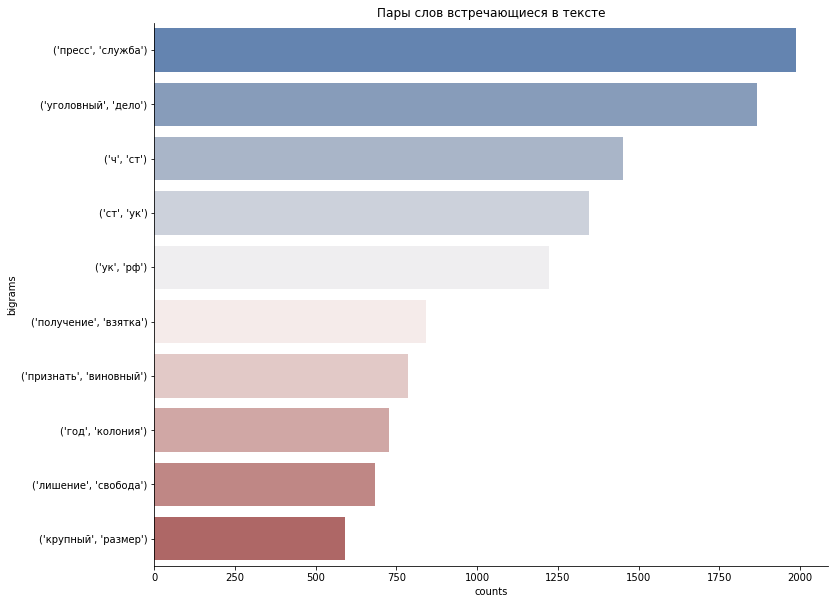

In [17]:
# Создаем датасет самых частотных биграммов
bigrams_series = (pd.Series(nltk.ngrams(allwords, 2)).value_counts())[:10]
bigrams_top = pd.DataFrame(bigrams_series.sort_values(ascending=False))
bigrams_top = bigrams_top.reset_index().rename(columns={'index': 'bigrams', 0:'counts'})

# Визуализация биграммов
plt.figure(figsize=(20,20))
sns.catplot(x = 'counts' , y='bigrams', kind="bar", palette="vlag", data=bigrams_top, height=8.27, aspect=11.7/8.27)
plt.title('Пары слов встречающиеся в тексте')

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(train['clean'], 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

пресс служба 1987
уголовный дело 1868
ст ук 1369
ук рф 1222
получение взятка 836
признать виновный 786
год колония 726
лишение свобода 683
крупный размер 592
сообщить пресс 563
млн рубль 561
возбудить уголовный 555
риа новость 529
следственный комитет 518
особо крупный 518
районный суд 509
лесной пожар 477
правоохранительный орган 466
приговорить год 456
предъявить обвинение 439
